In [1]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
import seaborn as sns
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
table = read_csv('/content/drive/MyDrive/Thesis/csvs/NNdata14_20.csv')
table.head()

Date  IDStation         NameStation  Ammonia  Arsenic  \
0  2014-01-01T00:00:00Z        681  Moggio Loc Penscei      0.0      NaN   
1  2014-01-02T00:00:00Z        681  Moggio Loc Penscei      0.0      NaN   
2  2014-01-03T00:00:00Z        681  Moggio Loc Penscei      0.0      1.1   
3  2014-01-04T00:00:00Z        681  Moggio Loc Penscei      0.0      NaN   
4  2014-01-05T00:00:00Z        681  Moggio Loc Penscei      0.0      NaN   

   Benzo_a_pyrene  Cadmium  Lead  Nikel  NO  ...  IDStation.2  \
0             0.1      NaN   NaN    NaN NaN  ...          111   
1             NaN      NaN   NaN    NaN NaN  ...          111   
2             NaN      0.0   1.1    4.2 NaN  ...          111   
3             0.1      NaN   NaN    NaN NaN  ...          111   
4             NaN      NaN   NaN    NaN NaN  ...          111   

               NameStation.1  Wind_speed  Wind_direction  Temperature  \
0  Cassina Valsassina Moggio    0.443554            99.0    -0.334965   
1  Cassina Valsassina Moggio    0.355915           105.0    -0.486111   
2  Cassina Valsassina Moggio    0.207631           120.0     2.220588   
3  Cassina Valsassina Moggio    1.024926           175.0     2.137063   
4  Cassina Valsassina Moggio    0.666721            94.0     2.416084   

   Relative_humidity  Global_radiation Wind_speed_max  Wind_direction_max  \
0          45.545455         58.097902       1.805594               143.0   
1          83.944444          0.000000       1.767361               153.0   
2          87.042254         30.514085       1.558451               152.0   
3          89.349650          0.202797       3.816783               164.0   
4          86.055944         10.951049       2.797203               136.0   

  Rainfall  
0      0.0  
1      7.8  
2      0.0  
3     35.8  
4     25.0  

[5 rows x 28 columns]

In [4]:
#Moggio = table.loc[table.loc[:,"NameStation"]=="Moggio",:]
#PM 2.5 were removed
Moggio = table.loc[:,["Date","PM10","Ammonia","Wind_speed","Wind_direction","Temperature","Rainfall"]]
Moggio = Moggio.dropna(how="any")
Moggio = Moggio.reset_index()
Moggio = Moggio.iloc[:-365,:] # we train not using 2020, for now
Moggio.head()


index                  Date  PM10  Ammonia  Wind_speed  Wind_direction  \
0      0  2014-01-01T00:00:00Z   6.0      0.0    0.443554            99.0   
1      1  2014-01-02T00:00:00Z   6.0      0.0    0.355915           105.0   
2      2  2014-01-03T00:00:00Z  11.0      0.0    0.207631           120.0   
3      3  2014-01-04T00:00:00Z   6.0      0.0    1.024926           175.0   
4      4  2014-01-05T00:00:00Z   3.0      0.0    0.666721            94.0   

   Temperature  Rainfall  
0    -0.334965       0.0  
1    -0.486111       7.8  
2     2.220588       0.0  
3     2.137063      35.8  
4     2.416084      25.0

In [ ]:
# sns.lineplot(x='Date', y='PM25', data=Moggio)

##Convert series to supervised learning
### Activation function = tanh and logistic (s curve)

###Conversion Function

In [5]:
from pandas import DataFrame
from pandas import concat
 
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	"""
	Frame a time series as a supervised learning dataset.
	Arguments:
		data: Sequence of observations as a list or NumPy array.
		n_in: Number of lag observations as input (X).
		n_out: Number of observations as output (y).
		dropnan: Boolean whether or not to drop rows with NaN values.
	Returns:
		Pandas DataFrame of series framed for supervised learning.
	"""
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

### Conversion of Moggio

In [6]:
values = Moggio.iloc[:,2:].values
# ensure all data is float
values = values.astype('float32') #cast in float 32 bit per evitare problemi
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
n_days = 5 #Memoria della NN
reframed = series_to_supervised(scaled, n_days, 5) # info of the past 5 days to determine next (5) day
# drop columns we don't want to predict (we therefore keep Ammonia)
#reframed.drop(reframed.columns[[31,32,33,34,35]], axis=1, inplace=True)

reframed.head()

var1(t-5)  var2(t-5)  var3(t-5)  var4(t-5)  var5(t-5)  var6(t-5)  \
5   0.066667        0.0   0.163005   0.275000   0.286365   0.000000   
6   0.066667        0.0   0.130139   0.291667   0.282413   0.035199   
7   0.122222        0.0   0.074531   0.333333   0.353183   0.000000   
8   0.066667        0.0   0.381024   0.486111   0.350999   0.161552   
9   0.033333        0.0   0.246694   0.261111   0.358295   0.112816   

   var1(t-4)  var2(t-4)  var3(t-4)  var4(t-4)  ...  var3(t+3)  var4(t+3)  \
5   0.066667        0.0   0.130139   0.291667  ...   0.063516   0.100000   
6   0.122222        0.0   0.074531   0.333333  ...   0.141334   0.738889   
7   0.066667        0.0   0.381024   0.486111  ...   0.068566   0.019444   
8   0.033333        0.0   0.246694   0.261111  ...   0.024003   0.188889   
9   0.022222        0.0   0.075776   0.222222  ...   0.122816   0.694444   

   var5(t+3)  var6(t+3)  var1(t+4)  var2(t+4)  var3(t+4)  var4(t+4)  \
5   0.392536   0.000000   0.133333        0.0   0.141334   0.738889   
6   0.409331   0.000000   0.122222        0.0   0.068566   0.019444   
7   0.387761   0.000000   0.066667        0.0   0.024003   0.188889   
8   0.425800   0.000000   0.177778        0.0   0.122816   0.694444   
9   0.335977   0.008123   0.066667        0.0   0.043570   0.833333   

   var5(t+4)  var6(t+4)  
5   0.409331   0.000000  
6   0.387761   0.000000  
7   0.425800   0.000000  
8   0.335977   0.008123  
9   0.294106   0.166967  

[5 rows x 60 columns]

In [ ]:
boo = []

for value in reframed.columns:
  boo.append(not(value.startswith("var1(t-"))) # remove the y from all the predictors, as to see how the model performs without the autoregressive component 

reframed = reframed.iloc[:,boo]


In [7]:
# split into train and test sets
values = reframed.values
n_features = 6 # number of variables, not including the one to be predicted
n_train_days = 1312 # we train using only the first year
train = values[:n_train_days, :]
test = values[n_train_days:, :] # we test using all successive years

boo = []
for value in reframed.columns:
  boo.append('var1(t)' in value or 'var1(t+' in value) # used to single out the future lags of var1 (and not of all others)

# split into input and outputs
n_obs = n_days * n_features
train_X, train_y = train[:, :n_obs], train[:, boo] 
test_X, test_y = test[:, :n_obs], test[:, boo]
print(train_X.shape, len(train_X), train_y.shape)
# reshape input to be 3D [samples, timesteps, features]
# reshape from 2D to 3D
train_X = train_X.reshape((train_X.shape[0], n_days, n_features))
test_X = test_X.reshape((test_X.shape[0], n_days, n_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(1312, 30) 1312 (1312, 5)
(1312, 5, 6) (1312, 5) (415, 5, 6) (415, 5)


# Modeling and training

Epoch 1/500
14/14 - 11s - loss: 0.1447 - val_loss: 0.0997 - 11s/epoch - 754ms/step
Epoch 2/500
14/14 - 0s - loss: 0.0989 - val_loss: 0.0929 - 226ms/epoch - 16ms/step
Epoch 3/500
14/14 - 0s - loss: 0.0969 - val_loss: 0.0910 - 235ms/epoch - 17ms/step
Epoch 4/500
14/14 - 0s - loss: 0.0954 - val_loss: 0.0907 - 242ms/epoch - 17ms/step
Epoch 5/500
14/14 - 0s - loss: 0.0955 - val_loss: 0.0898 - 234ms/epoch - 17ms/step
Epoch 6/500
14/14 - 0s - loss: 0.0947 - val_loss: 0.0895 - 227ms/epoch - 16ms/step
Epoch 7/500
14/14 - 0s - loss: 0.0943 - val_loss: 0.0889 - 237ms/epoch - 17ms/step
Epoch 8/500
14/14 - 0s - loss: 0.0936 - val_loss: 0.0883 - 232ms/epoch - 17ms/step
Epoch 9/500
14/14 - 0s - loss: 0.0930 - val_loss: 0.0878 - 232ms/epoch - 17ms/step
Epoch 10/500
14/14 - 0s - loss: 0.0929 - val_loss: 0.0878 - 225ms/epoch - 16ms/step
Epoch 11/500
14/14 - 0s - loss: 0.0930 - val_loss: 0.0884 - 224ms/epoch - 16ms/step
Epoch 12/500
14/14 - 0s - loss: 0.0927 - val_loss: 0.0881 - 222ms/epoch - 16ms/step
E

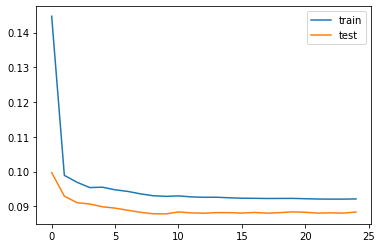

In [8]:
# design the neural network
model = Sequential()
model.add(LSTM(30, return_sequences=True, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(LSTM(30, return_sequences=True))
model.add(LSTM(30, return_sequences=True))
model.add(LSTM(30, return_sequences=True))
model.add(LSTM(30, return_sequences=False))
model.add(Dense(5)) # prediction for the following 6 days
model.compile(loss='mae', optimizer='adam')
# fit network
early_stopping = EarlyStopping(patience=15, restore_best_weights = True)
history = model.fit(train_X, train_y, epochs=500, batch_size=100, validation_data=(test_X, test_y), verbose=2, shuffle=False, callbacks=early_stopping)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

## Predictions of the year 2019

#### Prediciton plots

prediction with 2020

In [9]:
#Moggio = table.loc[table.loc[:,"NameStation"]=="Moggio",:]
#PM 2.5 were removed
Moggio = table.loc[:,["Date","PM10","Ammonia","Wind_speed","Wind_direction","Temperature","Rainfall"]]
Moggio = Moggio.dropna(how="any")
Moggio = Moggio.reset_index()
Moggio = Moggio.iloc[:,:] # this is the differrence!!!! we keep the 2020 data 
Moggio.head()
values = Moggio.iloc[:,2:].values

# ensure all data is float
values = values.astype('float32') #cast in float 32 bit per evitare problemi
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
n_days = 5 #Memoria della NN
reframed = series_to_supervised(scaled, n_days, 5) # info of the past 5 days to determine next (5) day
# drop columns we don't want to predict (we therefore keep Ammonia)
#reframed.drop(reframed.columns[[31,32,33,34,35]], axis=1, inplace=True)


# split into train and test sets
values = reframed.values
n_features = 6 # number of variables, not including the one to be predicted
n_train_days = 1312 # we train using only the first year
train = values[:n_train_days, :]
test = values[n_train_days:, :] # we test using all successive years

boo = []
for value in reframed.columns:
  boo.append('var1(t)' in value or 'var1(t+' in value) # used to single out the future lags of var1 (and not of all others)

# split into input and outputs
n_obs = n_days * n_features
train_X, train_y = train[:, :n_obs], train[:, boo] 
test_X, test_y = test[:, :n_obs], test[:, boo]
print(train_X.shape, len(train_X), train_y.shape)
# reshape input to be 3D [samples, timesteps, features]
# reshape from 2D to 3D
train_X = train_X.reshape((train_X.shape[0], n_days, n_features))
test_X = test_X.reshape((test_X.shape[0], n_days, n_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)


(1312, 30) 1312 (1312, 5)
(1312, 5, 6) (1312, 5) (780, 5, 6) (780, 5)


In [10]:
# make a prediction
yhat = model.predict(test_X)

In [11]:
#Convert from 3D to 2D
test_X = test_X.reshape((test_X.shape[0], n_days*n_features))
#scale back both the prediction and the test dataset
inv_yhat = []
inv_y = []
a = -5
b = test_X.shape[1]
for i in range(1,yhat.shape[1]+1):

  t = concatenate((yhat[:,(i-1):i], test_X[:, a:b]), axis=1)
  t = scaler.inverse_transform(t)
  inv_yhat.append(t[:,0])

  t = concatenate((test_y[:,(i-1):i], test_X[:, a:b]), axis=1)
  t = scaler.inverse_transform(t)
  inv_y.append(t[:,0])

  a = a - 5
  b = b - 5


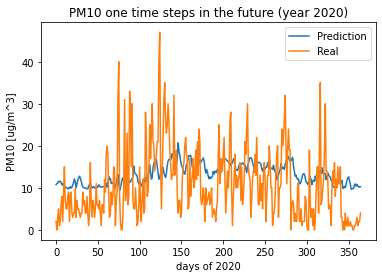

Test RMSE: 9.215


In [12]:
pyplot.plot(inv_yhat[0][-365:], label = 'Prediction')
pyplot.plot(inv_y[0][-365:][-365:], label = 'Real')
pyplot.legend()
pyplot.title("PM10 one time steps in the future (year 2020)")
pyplot.xlabel('days of 2020') 
pyplot.ylabel('PM10 [ug/m^3]') 
pyplot.show()
rmse = sqrt(mean_squared_error(inv_y[0], inv_yhat[0]))
print('Test RMSE: %.3f' % rmse)

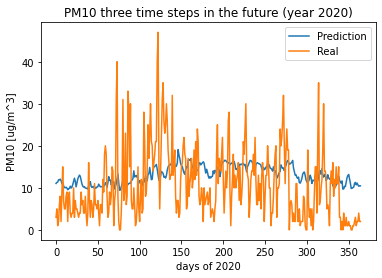

Test RMSE: 9.349


In [ ]:
pyplot.plot(inv_yhat[2][-365:], label = 'Prediction')
pyplot.plot(inv_y[2][-365:][-365:], label = 'Real')
pyplot.legend()
pyplot.title("PM10 three time steps in the future (year 2020)")
pyplot.xlabel('days of 2020') 
pyplot.ylabel('PM10 [ug/m^3]') 
pyplot.show()
rmse = sqrt(mean_squared_error(inv_y[2], inv_yhat[2]))
print('Test RMSE: %.3f' % rmse)

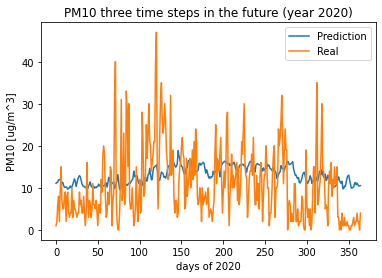

Test RMSE: 9.420


In [ ]:
pyplot.plot(inv_yhat[4][-365:], label = 'Prediction')
pyplot.plot(inv_y[4][-365:][-365:], label = 'Real')
pyplot.legend()
pyplot.title("PM10 three time steps in the future (year 2020)")
pyplot.xlabel('days of 2020') 
pyplot.ylabel('PM10 [ug/m^3]') 
pyplot.show()
rmse = sqrt(mean_squared_error(inv_y[4], inv_yhat[4]))
print('Test RMSE: %.3f' % rmse)

# Lime


In [ ]:
!pip install lime

In [ ]:
from lime import lime_tabular

In [ ]:
test_X.shape

In [ ]:
explainer = lime_tabular.RecurrentTabularExplainer(test_X, feature_names=["PM10","Ammonia","Wind_speed","Wind_direction","Temperature","Rainfall"], mode='regression')

In [ ]:
exp = explainer.explain_instance(test_X[50], model.predict, num_features=6,labels=(1,))
exp.show_in_notebook()

In [ ]:
exp = explainer.explain_instance(test_X[49], model.predict, num_features=6,labels=(1,))
exp.show_in_notebook()

In [ ]:
exp = explainer.explain_instance(test_X[75], model.predict, num_features=6,labels=(1,))
exp.show_in_notebook()

In [ ]:
test_X[1]

In [ ]:
exp.as_list()